통계적 사고 (2판) 연습문제 ([thinkstats2.com](thinkstats2.com), [think-stat.xwmooc.org](http://think-stat.xwmooc.org))<br>
Allen Downey / 이광춘(xwMOOC)

In [4]:
from __future__ import print_function

import pandas
import numpy as np
import statsmodels.formula.api as smf

import thinkplot
import thinkstats2
import regression
import timeseries
%matplotlib inline

## 연습문제 12.1

이번 장에서 저자가 사용한 선형모형은 선형이라는 명백한 결점이 있고, 가격이 시간에 따라 선형으로 변할 것이라고 예측할 이유는 없다. 11.3 절에서 했던 것처럼, 2차항을 추가해서 모형에 유연성을 더할 수 있다.
2차 모형을 사용해서 시계열 일별가격을 적합할 수 있고, 모형을 사용해서 예측값도 생성할 수 있다. 2차 모형을 돌리는 RunLinearModel 버젼을 작성해야할 것이다. 하지만, 예측을 생성하는데 timeseries.py에 나온 코드를 재사용할 수도 있다.

Intercept   13.7   (0)
years   -1.12   (5.86e-38)
years2   0.113   (4.82e-07)
R^2 0.4553
Std(ys) 1.096
Std(res) 0.809
Writing timeseries11.pdf
Writing timeseries11.eps


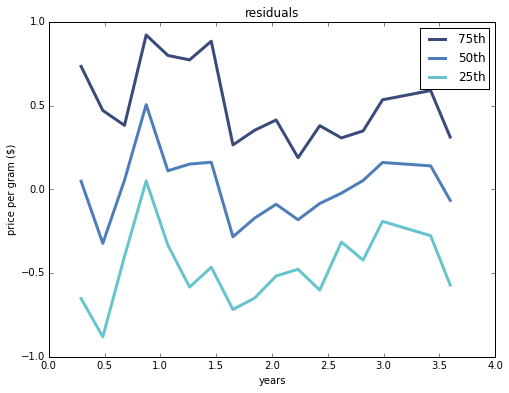

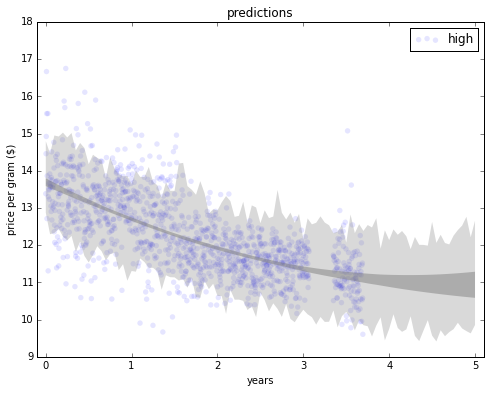

In [6]:
def RunQuadraticModel(daily):
    """Runs a linear model of prices versus years.

    daily: DataFrame of daily prices

    returns: model, results
    """
    daily['years2'] = daily.years**2
    model = smf.ols('ppg ~ years + years2', data=daily)
    results = model.fit()
    return model, results

def PlotQuadraticModel(daily, name):
    """
    """
    model, results = RunQuadraticModel(daily)
    regression.SummarizeResults(results)
    timeseries.PlotFittedValues(model, results, label=name)
    thinkplot.Save(root='timeseries11',
                   title='fitted values',
                   xlabel='years',
                   xlim=[-0.1, 3.8],
                   ylabel='price per gram ($)')

    timeseries.PlotResidualPercentiles(model, results)
    thinkplot.Show(title='residuals',
                   xlabel='years',
                   ylabel='price per gram ($)')

    years = np.linspace(0, 5, 101)
    thinkplot.Scatter(daily.years, daily.ppg, alpha=0.1, label=name)
    timeseries.PlotPredictions(daily, years, func=RunQuadraticModel)
    thinkplot.Show(title='predictions',
                   xlabel='years',
                   xlim=[years[0]-0.1, years[-1]+0.1],
                   ylabel='price per gram ($)')

transactions = timeseries.ReadData()

dailies = timeseries.GroupByQualityAndDay(transactions)
name = 'high'
daily = dailies[name]

PlotQuadraticModel(daily, name)

## 연습문제 12.2

9.2 절에 나온 HypothesisTest을 확장하는 클래스를 정의하는데 명칭은 SerialCorrelationTest이다. 데이터로 시계열과 시차(lag)를 받아서, 주어진 시차를 갖는 시계열 데이터의 계열상관을 계산하고 나서, 관측된 상관에 대한 p-값을 계산한다.

이 클래스를 사용해서 원가격 데이터에 나온 계열 상관이 통계적으로 유의적인지 검정한다. 또한, 선형모형과 (만약 이전 예제를 수행했다면) 2차 모형의 잔차를 검정한다.

In [9]:
class SerialCorrelationTest(thinkstats2.HypothesisTest):
    """Tests serial correlations by permutation."""

    def TestStatistic(self, data):
        """Computes the test statistic.

        data: tuple of xs and ys
        """
        series, lag = data
        test_stat = abs(thinkstats2.SerialCorr(series, lag))
        return test_stat

    def RunModel(self):
        """Run the model of the null hypothesis.

        returns: simulated data
        """
        series, lag = self.data
        permutation = series.reindex(np.random.permutation(series.index))
        return permutation, lag

    
def TestSerialCorr(daily):
    """Tests serial correlations in daily prices and their residuals.

    daily: DataFrame of daily prices
    """
    # test the correlation between consecutive prices
    series = daily.ppg
    test = SerialCorrelationTest((series, 1))
    pvalue = test.PValue()
    print(test.actual, pvalue)

    # test for serial correlation in residuals of the linear model
    _, results = timeseries.RunLinearModel(daily)
    series = results.resid
    test = SerialCorrelationTest((series, 1))
    pvalue = test.PValue()
    print(test.actual, pvalue)

    # test for serial correlation in residuals of the quadratic model
    _, results = RunQuadraticModel(daily)
    series = results.resid
    test = SerialCorrelationTest((series, 1))
    pvalue = test.PValue()
    print(test.actual, pvalue)

TestSerialCorr(daily)    

0.485229376195 0.0
0.0757047376751 0.004
0.0560730816129 0.042


## 연습문제 12.3

예측을 만들어 내는데, EWMA 모형을 확장하는 몇가지 방식이 있다. 가장 단순한 방법중의 하나는 다음과 같다:
시계열 EWMA를 계산하고, 가장 마지막 점을 절편 inter으로 사용한다.
시계열의 연속 요소사이에 EWMA 차이를 계산하고, 가장 마지막 점을 기울기 slope로 사용한다.
미래 시점에 값을 예측하는데, inter + slope * dt을 계산한다. 여기서 dt는 예측 시점과 가장 마지막 예측 시점의 차이다.
이 방법을 사용해서, 마지막 관측점 다음 연도에 대한 예측을 생성한다. 

몇가지 힌드는 다음과 같다:
timeseries.FillMissing을 사용해서 분석을 돌리기 전에 결측값을 채워넣는다. 이런 방식으로 연속된 요소값 사이 시점이 일치한다.
Series.diff을 사용해서 연속된 요소 사이 차이를 계산한다.
reindex을 사용해서 데이터프레임을 미래로 연장한다.
fillna을 사용해서 예측한 값을 데이터프레임에 넣는다.

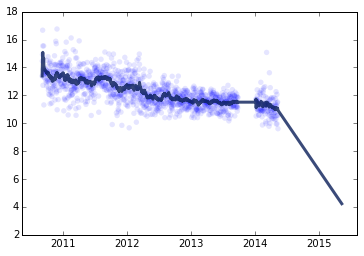

In [10]:
def PlotEwmaPredictions(daily, name):
    """
    """

    # use EWMA to estimate slopes
    filled = timeseries.FillMissing(daily)
    filled['slope'] = pandas.ewma(filled.ppg.diff(), span=180)
    filled[-1:]

    # extract the last inter and slope
    start = filled.index[-1]
    inter = filled.ewma[-1]
    slope = filled.slope[-1]

    # reindex the DataFrame, adding a year to the end
    dates = pandas.date_range(filled.index.min(), 
                              filled.index.max() + np.timedelta64(365, 'D'))
    predicted = filled.reindex(dates)

    # generate predicted values and add them to the end
    predicted['date'] = predicted.index
    one_day = np.timedelta64(1, 'D')
    predicted['days'] = (predicted.date - start) / one_day
    predict = inter + slope * predicted.days
    predicted.ewma.fillna(predict, inplace=True)

    # plot the actual values and predictions
    thinkplot.Scatter(daily.ppg, alpha=0.1, label=name)
    thinkplot.Plot(predicted.ewma)
    thinkplot.Show(legend=False)

PlotEwmaPredictions(daily, name)    